In [1]:
# Enable continuous module reloading
%load_ext autoreload
%autoreload 2

# Standard library
import os
import sys
sys.path.append('..')
# External library
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Custom modules
from src import utils
from src.consensus import *
from src.aggregator import EmbeddingAggregator
# from src import pipeline

And set some global variables.


In [2]:
# Plotting settings
from process_data import PROCESSED_DIR


colorstyle = "RdBu"
sns.set_style("dark")
sns.set_palette(colorstyle)

# Pandas settings
pd.options.display.max_colwidth = 150

# Subsetting options
SUBSET = True 
NUM_SUBSET_SAMPLES = 10_000 # Expects that `process_data.py --limit NUM_SUBSET_SAMPLES`

# Paths
ROOT_DIR = os.getcwd()
ROOT_DIR = os.path.join(ROOT_DIR, "..")
DATA_DIR = os.path.join(ROOT_DIR, "data")
PROCESSED_DIR = os.path.join(DATA_DIR, "processed")

# Random seed
SEED = 42
np.random.seed(SEED)
SHUFFLE_REVIEWS = True 

# Type of metric
METRIC = "cosine"  # cosine, kl, js, correlation
MAX_SAMPLES = 10_000 # Maximum number of samples for a specific group
MIN_NUM_REVIEWS = 30 # Minimum number of reviews for a beer to be included in the analysis

# Ensure data directory exists
os.makedirs(DATA_DIR, exist_ok=True)

In [3]:
reviews = utils.load_data(PROCESSED_DIR, None, False, None)
embeddings = utils.load_embeddings(PROCESSED_DIR, None)
assert len(reviews) == embeddings.shape[0]
print(f"Loaded {len(reviews)} reviews and {embeddings.shape[0]} embeddings.")
embeddings, reviews = utils.filter_data(embeddings, reviews, 30)
print(f"Filtered to {len(reviews)} reviews and {embeddings.shape[0]} embeddings.")
if SHUFFLE_REVIEWS:
    random_indices = np.random.permutation(embeddings.shape[0])
    embeddings = embeddings[random_indices]
    print("Shuffled reviews.")

Loaded 2400935 reviews and 2400935 embeddings.
Filtered to 1763726 reviews and 1763726 embeddings.
Shuffled reviews.


In [8]:
# Chosen extractor, embedder and consensus model
consensus: ConsensusBase
if METRIC == "cosine":
    consensus =CosineSimilarity()
    print("Using cosine consensus")
elif METRIC == "correlation":
    consensus = Correlation()
    print("Using correlation consensus")
elif METRIC == "kl":
    consensus = KullbackLeiblerDivergence()
    print("Using KL consensus")
elif METRIC == "js":
    consensus = JensenShannonDivergence()
    print("Using JS consensus")
else:
    raise ValueError("Invalid metric")

beer_aggregator = EmbeddingAggregator(embeddings,reviews, consensus, ('beer', 'name'))
style_aggregator = EmbeddingAggregator(embeddings,reviews, consensus, ('beer', 'style'))
substyle_aggregator = EmbeddingAggregator(embeddings,reviews, consensus, ('beer', 'substyle'))
gereral_aggregator = EmbeddingAggregator(embeddings,reviews, consensus, None)

print(f"Beer groups: {len(beer_aggregator.groups)}")
print(f"Style groups: {len(style_aggregator.groups)}")
print(f"Substyle groups: {len(substyle_aggregator.groups)}")
print(f"General groups: {len(gereral_aggregator.groups)}")

Using cosine consensus
Beer groups: 24763
Style groups: 11
Substyle groups: 104
General groups: 1


### First experiment

Here we try to calculate the average consenus for each group at each level dute to the computational restrictions we take only a sample for the large groups.

In [9]:
# Make a nice df
levels = ["General", "Style", "Substyle", "Beer"]
consensus_levels = [
    gereral_aggregator,
    style_aggregator,
    substyle_aggregator,
    beer_aggregator,
]
MAX_SAMPLES = 10000
consensus_df = []
for level, consensus_level in zip(levels, consensus_levels):
    for group in tqdm(consensus_level.groups, desc=f"Processing Group {level}"):
        con = consensus_level.get_consensus_distribution(group, max_samples=MAX_SAMPLES).mean()

        consensus_df.append(
            {
                "level": level,
                "group": group,
                "consensus": con,
            }
        )

consensus_df = pd.DataFrame(consensus_df)
# save
print(f"️✅ Created consensus dataframe of shape {consensus_df.shape}.")

Processing Group Beer: 100%|██████████| 24763/24763 [38:19<00:00, 10.77it/s] 


️✅ Created consensus dataframe of shape (24879, 3).


In [10]:
# Compute the mean consensus dataframe
mean_consensus_df = consensus_df.groupby(by=["level"])["consensus"].mean()
mean_consensus_df.reindex(levels)

level
General     0.052502
Style       0.052467
Substyle    0.052586
Beer        0.052549
Name: consensus, dtype: float64

✅ Plotted distribution of all consensus scores in levels.


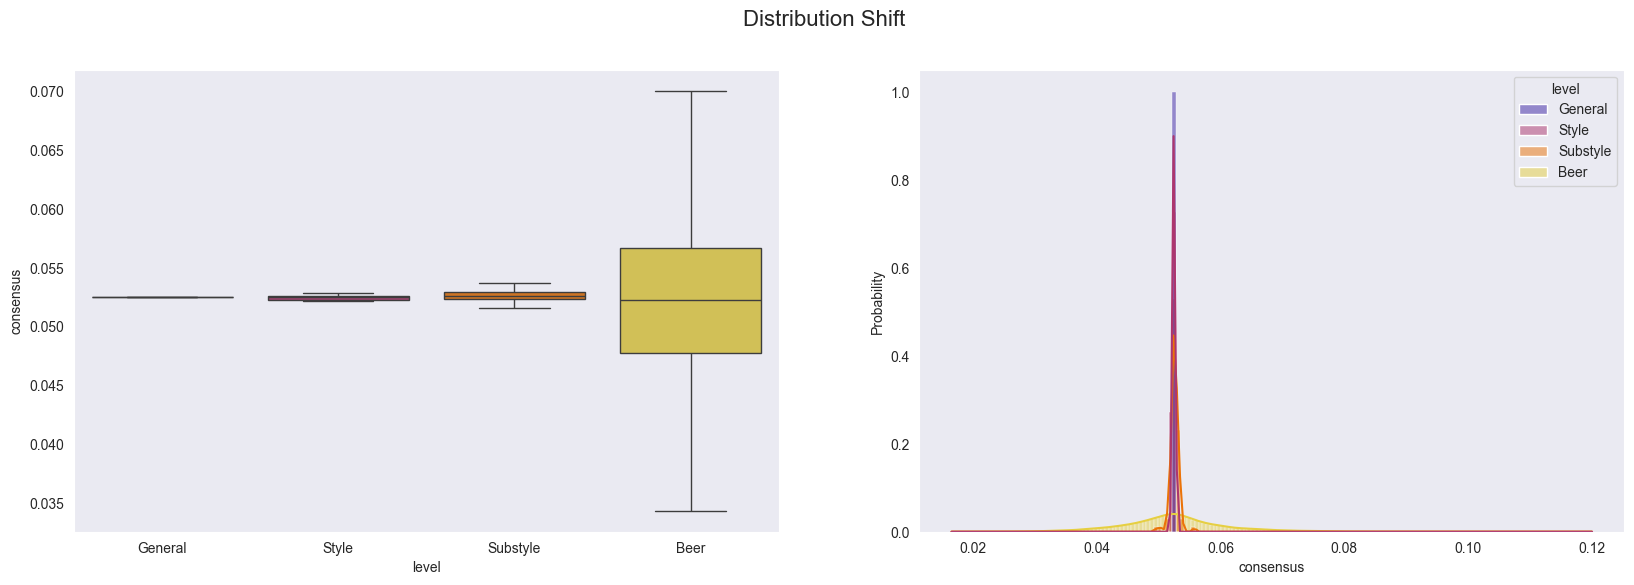

In [11]:
# Plot distributions of mean consensus scores
fig, axs = plt.subplots(ncols=2, figsize=(20, 6))
fig.suptitle("Distribution Shift", fontsize=16)

# Boxplot of consensus scores per level
sns.boxplot(
    data=consensus_df,
    x="level",
    y="consensus",
    hue="level",
    order=levels,
    showfliers=False,
    palette="CMRmap",
    ax=axs[0],
)

# Distplot of consensus scores per level
sns.histplot(
    data=consensus_df,
    x="consensus",
    hue="level",
    stat="probability",
    kde=True,
    fill=True,
    common_norm=False,
    palette="CMRmap",
    ax=axs[1]
)

print(f"✅ Plotted distribution of all consensus scores in levels.")

### Statistical Tests

We pefrom a statistical test with the null hypothesis that the average consensus scores in each level of grouping are the same. We use the ANOVA test to test this hypothesis at the 1% significance level. We have different number of samples in each group, so we use the type 2 ANOVA test which is more robust to unequal sample sizes. [Source](https://www.r-bloggers.com/2011/03/anova-%e2%80%93-type-iiiiii-ss-explained/)

In [55]:
# consensus_df = consensus_df[consensus_df['level'] != 'General']

In [12]:
# We first need to fit an OLS model
model = ols("consensus ~ C(level)", data=consensus_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(level),2.131981e-07,3.0,0.00091,0.999962
Residual,1.941714e+00,24875.0,NaN,NaN


In [13]:
print(
    f"The test statistic is {anova_table.iloc[0]['F']:.2f} and the p-value is {anova_table.iloc[0]['PR(>F)']:.2f}."
)

The test statistic is 0.00 and the p-value is 1.00.


In [14]:
turkey_results = pairwise_tukeyhsd(
   consensus_df['consensus'],consensus_df['level'], alpha=0.01
)
turkey_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Beer,General,-0.0,1.0,-0.0276,0.0275,False
Beer,Style,-0.0001,1.0,-0.0084,0.0082,False
Beer,Substyle,0.0,1.0,-0.0027,0.0027,False
General,Style,-0.0,1.0,-0.0288,0.0287,False
General,Substyle,0.0001,1.0,-0.0276,0.0277,False
Style,Substyle,0.0001,1.0,-0.0086,0.0088,False


### Second experiment

Here we try something a bit faster we compute the average embedding for each group at each level and then compute the consensus among the average embeddings. This than reverses the trend we now expect that the average consensus will be higher for the most specific groups.

In [15]:
levels = ["Style", "Substyle", "Beer"]
consensus_levels = [
    style_aggregator,
    substyle_aggregator,
    beer_aggregator,
]
disagreement_df = pd.DataFrame()
for level, consensus_level in zip(levels, consensus_levels):
    dist = consensus_level.get_overall_consensus_distribution()
    dist = pd.DataFrame(dist, columns=["consensus"])
    dist["level"] = level
    disagreement_df= pd.concat([disagreement_df, dist])


# save
print(f"️✅ Created consensus dataframe of shape {disagreement_df.shape}.")

Calculating average embeddings: 100%|██████████| 24763/24763 [41:59<00:00,  9.83it/s] 


️✅ Created consensus dataframe of shape (306596114, 2).


In [72]:
mean_disagreement_df = consensus_df.groupby("level").mean().reindex(levels)
mean_disagreement_df

,consensus
level,
Style,0.999853
Substyle,0.992619


✅ Plotted distribution of all consensus scores in levels.


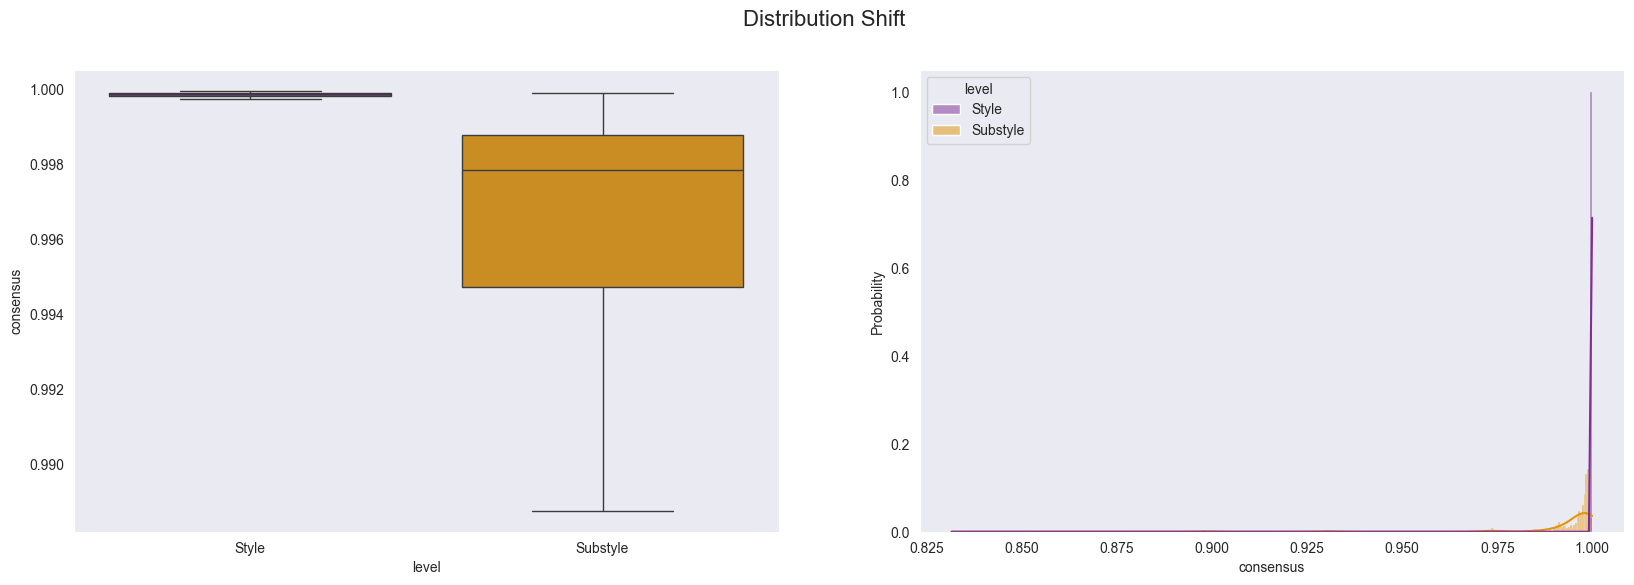

In [71]:
# Plot distributions of mean consensus scores
fig, axs = plt.subplots(ncols=2, figsize=(20, 6))
fig.suptitle("Distribution Shift", fontsize=16)

# Boxplot of consensus scores per level
sns.boxplot(
    data=mean_disagreement_df,
    x="level",
    y="consensus",
    hue="level",
    order=levels,
    showfliers=False,
    palette="CMRmap",
    ax=axs[0],
)

# Distplot of consensus scores per level
sns.histplot(
    data=mean_disagreement_df,
    x="consensus",
    hue="level",
    stat="probability",
    kde=True,
    fill=True,
    common_norm=False,
    palette="CMRmap",
    ax=axs[1],
)

print(f"✅ Plotted distribution of all consensus scores in levels.")

In [68]:
# We first need to fit an OLS model
model = ols("consensus ~ C(level)", data=consensus_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(level),0.002849,1.0,9.587046,0.00197
Residual,1.607407,5409.0,NaN,NaN


In [ ]:
print(
    f"The test statistic is {anova_table.iloc[0]['F']:.2f} and the p-value is {anova_table.iloc[0]['PR(>F)']:.2f}."
)

In [70]:
turkey_results = pairwise_tukeyhsd(
    consensus_df["consensus"],
    consensus_df["level"],
    alpha=0.01,
)
turkey_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Style,Substyle,-0.0072,0.002,-0.0133,-0.0012,True


### Conduct experiments with different metrics


In [3]:
import pickle


metrics = [
    Correlation(),
    KullbackLeiblerDivergence(),
    CosineSimilarity(),
    JensenShannonDivergence(),
]
shuffle = [True, False]
MAX_SAMPLES = 10000
levels1 = ["General", "Style", "Substyle", "Beer"]
levels2 = ["Style", "Substyle", "Beer"]
experiements = []

for metric in metrics:
    for shuf in shuffle:
        reviews = utils.load_data(PROCESSED_DIR, None, False, None)
        embeddings = utils.load_embeddings(PROCESSED_DIR)
        embeddings, reviews = utils.filter_data(embeddings, reviews, 30)

        if shuf:
            random_indices = np.random.permutation(len(reviews))
            embeddings = embeddings[random_indices]

        beer_con = EmbeddingAggregator(embeddings, reviews, metric, ("beer", "name"))
        style_aggregator = EmbeddingAggregator(
            embeddings, reviews, metric, ("beer", "style")
        )
        substyle_aggregator = EmbeddingAggregator(
            embeddings, reviews, metric, ("beer", "substyle")
        )
        gereral_aggregator = EmbeddingAggregator(embeddings, reviews, metric, None)
        # First experiment
        consensus_levels1 = [
            gereral_aggregator,
            style_aggregator,
            substyle_aggregator,
            beer_con,
        ]
        consensus_df = []
        for level, consensus_level in zip(levels1, consensus_levels1):
            for group in tqdm(consensus_level.groups, desc=f"Processing Group {level}"):
                con = consensus_level.get_consensus_distribution(
                    group, max_samples=MAX_SAMPLES
                ).mean()

                consensus_df.append(
                    {
                        "level": level,
                        "group": group,
                        "consensus": con,
                        "metric": metric,
                        "shuffle": shuf,
                    }
                )
        consensus_df = pd.DataFrame(consensus_df)
        mean_consensus_df = (
            consensus_df.groupby(by=["level"])["consensus"].mean().reindex(levels1)
        )
        model1 = ols("consensus ~ C(level)", data=consensus_df).fit()
        anova_table1 = sm.stats.anova_lm(model1, typ=2)
        turkey_results1 = pairwise_tukeyhsd(
            consensus_df["consensus"],
            consensus_df["level"],
            alpha=0.01,
        )

        # Second experiment
        consensus_levels2 = [style_aggregator, substyle_aggregator, beer_con]
        consensus_df = pd.DataFrame()
        for level, consensus_level in zip(levels2, consensus_levels2):
            dist = consensus_level.get_overall_consensus_distribution()
            dist = pd.DataFrame(dist, columns=["consensus"])
            dist["level"] = level
            dist["shuffle"] = shuf
            consensus_df = pd.concat([consensus_df, dist])
        mean_disagreement_df = (
            consensus_df.groupby("level")["consensus"].mean().reindex(levels2)
        )
        model2 = ols("consensus ~ C(level)", data=consensus_df).fit()
        anova_table2 = sm.stats.anova_lm(model2, typ=2)
        turkey_results2 = pairwise_tukeyhsd(
            consensus_df["consensus"],
            consensus_df["level"],
            alpha=0.01,
        )
        result = {}
        result["metric"] = type(metric).__name__
        result["shuffle"] = shuf
        result["anova_table1"] = anova_table1
        result["turkey_results1"] = turkey_results1
        result["anova_table2"] = anova_table2
        result["turkey_results2"] = turkey_results2
        result["mean_consensus_df"] = mean_consensus_df
        result["mean_disagreement_df"] = mean_disagreement_df
        experiements.append(result)
        print(f"✅ Finished experiment with {metric} and shuffle {shuf}.")

        # Save results disctionary as binary file
        with open(os.path.join(PROCESSED_DIR, "experiments2.pkl"), "wb") as f:
            pickle.dump(experiements, f)

print(f"✅ Saved results dictionary as binary file.")
# load results
with open(os.path.join(PROCESSED_DIR, "experiments2.pkl"), "rb") as f:
    experiements_loaded = pickle.load(f)

Processing Group General:   0%|          | 0/1 [00:00<?, ?it/s]